In [1]:
import tensorflow as tf
from tensorflow import data
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation
from tensorflow.keras import layers, Input, Model
from tensorflow.keras import losses
from tensorflow.keras import optimizers
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import cv2
from collections import defaultdict
%matplotlib inline

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 6GB 메모리만 할당하도록 제한
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0], 
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6144)])
    except RuntimeError as e:
        print(e)

In [3]:
data_path = './dataset/'
train_data = glob.glob(data_path + 'train/*.jpg')
test_data = glob.glob(data_path + 'test/*.jpg')

print(f'number of train samples : {len(train_data)}')
print(f'number of test samples : {len(test_data)}')

number of train samples : 830
number of test samples : 20


In [4]:
train_data

['./dataset/train\\0.jpg',
 './dataset/train\\1.jpg',
 './dataset/train\\10.jpg',
 './dataset/train\\100.jpg',
 './dataset/train\\101.jpg',
 './dataset/train\\102.jpg',
 './dataset/train\\103.jpg',
 './dataset/train\\104.jpg',
 './dataset/train\\105.jpg',
 './dataset/train\\106.jpg',
 './dataset/train\\107.jpg',
 './dataset/train\\108.jpg',
 './dataset/train\\109.jpg',
 './dataset/train\\11.jpg',
 './dataset/train\\110.jpg',
 './dataset/train\\111.jpg',
 './dataset/train\\112.jpg',
 './dataset/train\\113.jpg',
 './dataset/train\\114.jpg',
 './dataset/train\\115.jpg',
 './dataset/train\\116.jpg',
 './dataset/train\\117.jpg',
 './dataset/train\\118.jpg',
 './dataset/train\\119.jpg',
 './dataset/train\\12.jpg',
 './dataset/train\\120.jpg',
 './dataset/train\\121.jpg',
 './dataset/train\\122.jpg',
 './dataset/train\\123.jpg',
 './dataset/train\\124.jpg',
 './dataset/train\\125.jpg',
 './dataset/train\\126.jpg',
 './dataset/train\\127.jpg',
 './dataset/train\\128.jpg',
 './dataset/train\\12

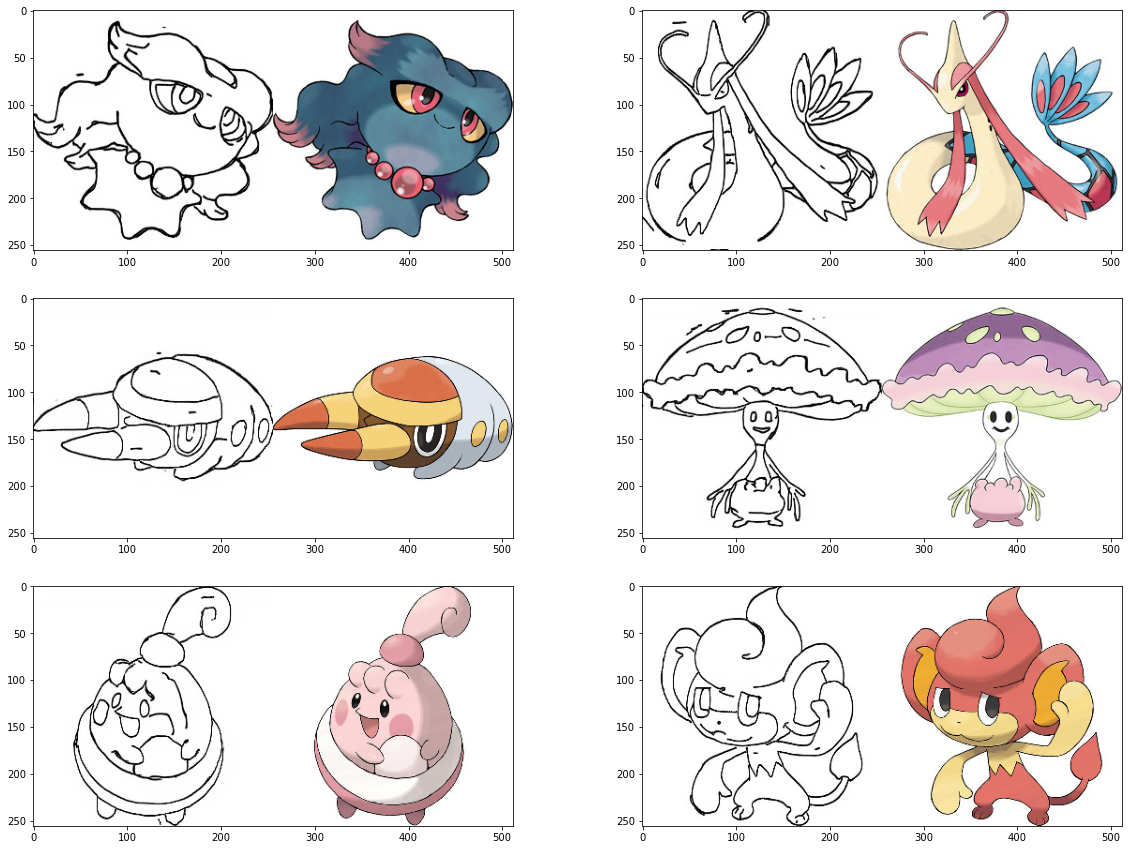

In [5]:
plt.figure(figsize=(20, 15))
for i in range(1, 7):
    f = train_data[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3, 2, i)
    plt.imshow(img)

In [6]:
f = train_data[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


In [7]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x / 127.5) - 1

def denormalize(x):
    x = (x + 1) * 127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :]
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :]
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

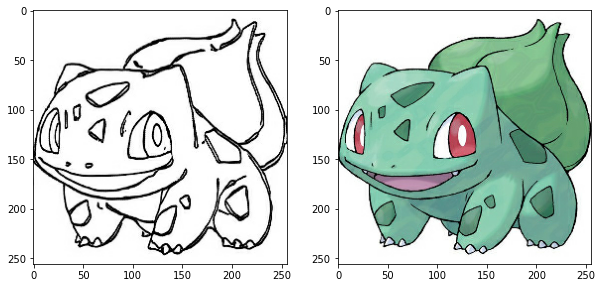

In [8]:
sketch, colored = load_img(f)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1); plt.imshow(denormalize(sketch))
plt.subplot(1, 2, 2); plt.imshow(denormalize(colored))

In [9]:
@tf.function()
def apply_augmentation(sketch, colored):
    # 두 이미지를 채널 축으로 연결
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30, 30], [30, 30], [0, 0]])
    # 50% 확률로 Refection padding 또는 constant padding 적용
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)
    
    # 임의로 crop
    out = image.random_crop(padded, size=[256, 256, 6])
    
    # 50% 확률로 상하좌우 반전
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    # 50% 확률로 회전
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
        
    return out[..., :3], out[..., 3:]

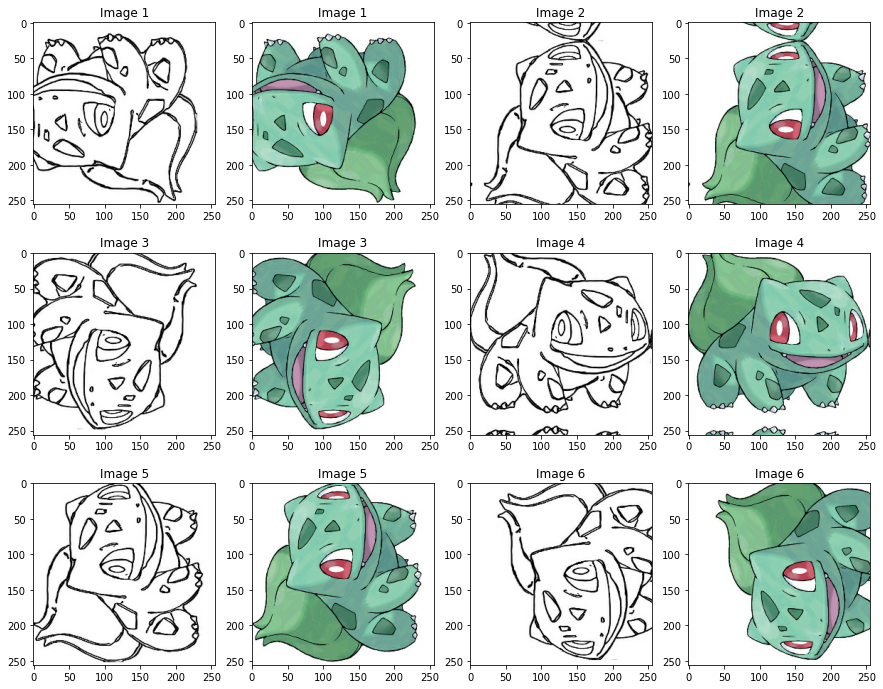

In [10]:
plt.figure(figsize=(15, 12))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3, 4, i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f'Image {img_n}')
    plt.subplot(3, 4, i+1)
    plt.imshow(denormalize(augmented_colored)); plt.title(f'Image {img_n}')
    img_n += 1

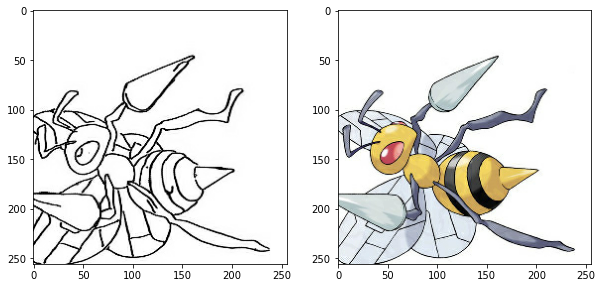

In [11]:
def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(train_data)
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

In [12]:
# Encoder
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

In [13]:
# Decoder   
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [14]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        # Encoder의 마지막 출력은 Decoder로 직접 입력되므로 Skip Connection에서 제외
        features = features[:-1]

        # feature의 역순으로 Skip Connection
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat]) # 가장 마지막 축(Channel) 기준으로 연결
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [15]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

In [16]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            # 1 만큼 ZeroPadding
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [17]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_15 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [18]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [19]:
Discriminator().get_summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

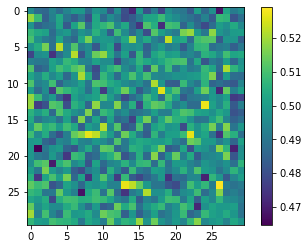

In [20]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

In [21]:
bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

In [22]:
def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [23]:
gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [24]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [25]:
EPOCHS = 1000

generator = UNetGenerator()
discriminator = Discriminator()
history = defaultdict(list)

test_ind = 0

f = train_data[test_ind]
sample_sketch, sample_colored = load_img(f)

In [26]:
def generate_and_save_image(epoch):
    pred = generator(tf.expand_dims(sample_sketch, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(5, 5))
    plt.imshow(pred[0])
    plt.savefig(f'./result/sample_epoch_{epoch:04d}')

In [ ]:
for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)

        # 50회 반복마다 손실을 출력
        if (i+1) % 50 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")
    history['g_loss'].append(g_loss)
    history['l1_loss'].append(l1_loss)
    history['d_loss'].append(d_loss)
    
    generate_and_save_image(epoch)
        
    if epoch % 100 == 0:
        generator.save(f'./model/generator/epoch_{epoch:04d}')
        discriminator.save_weights(f'./model/discriminator/epoch_{epoch:04d}.h5')

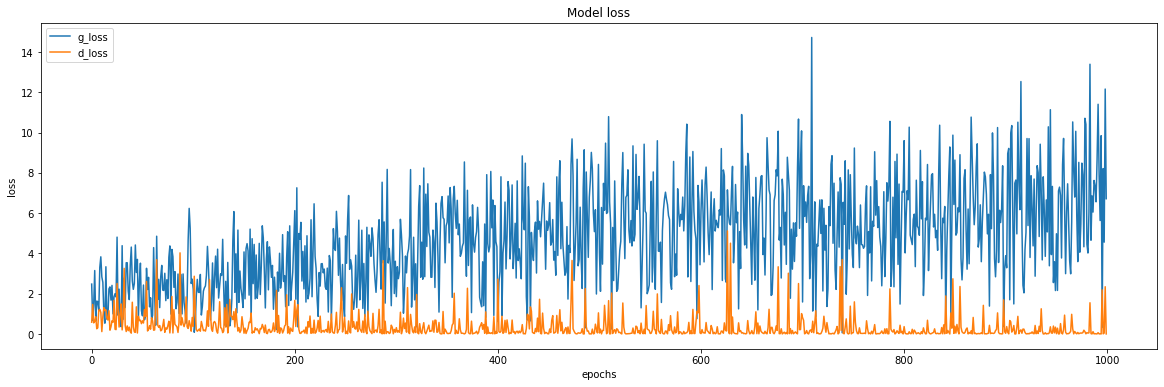

In [36]:
plt.figure(figsize=(20, 6))
plt.plot(history['g_loss'])
plt.plot(history['d_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['g_loss', 'd_loss'], loc='upper left')

In [3]:
import imageio
import glob
# git 파일로 저장
anim_file = 'result.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('./result/*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)